In [22]:
import torch
from torch.autograd import Variable
from nltk import CFG, Nonterminal, ChartParser
import re

grammar = """
S -> 'mul' S S
S -> 'sub' S S
S -> 'add' S S
S -> 'div' S S
S -> 'sin' S
S -> 'exp' S
S -> 'x1'
S -> '[CONST]'
Nothing -> None"""

GCFG = CFG.fromstring(grammar)

S, T = Nonterminal('S'), Nonterminal('T')

def get_mask(nonterminal, grammar, as_variable=False):
    if isinstance(nonterminal, Nonterminal):
        mask = [rule.lhs() == nonterminal for rule in grammar.productions()]
        mask = Variable(torch.FloatTensor(mask)) if as_variable else mask
        return mask
    else:
        raise ValueError('Input must be instance of nltk.Nonterminal')


pattern = r'-?\b(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?\b'
consts = []

def replace_and_collect(match):
    consts.append(match.group())
    return '[CONST]'

_productions = GCFG.productions()
_parser = ChartParser(GCFG)
_prod_map = {prod: idx for idx, prod in enumerate(_productions)}


eq = 'exp(x1*exp(0.998916506767273))'

from utils import create_generator
import sympy as sp


datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expr_240811_1.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

for eq in eqs[:10]:
    gen, params = create_generator('./data_settings.json')

    expr = sp.simplify(eq)
    prefix = gen.sympy_to_prefix(expr)
    # print(prefix)
    prefix = [re.sub(pattern, replace_and_collect, token) for token in prefix]
    # prefix[1] = '[CONST]'
    print(prefix)

    tree = next(_parser.parse(prefix))
    print(tree.productions())

['[CONST]']
[S -> '[CONST]']
['[CONST]']
[S -> '[CONST]']
['add', '[CONST]', 'mul', '[CONST]', 'x1']
[S -> 'add' S S, S -> '[CONST]', S -> 'mul' S S, S -> '[CONST]', S -> 'x1']
['add', '[CONST]', 'mul', '[CONST]', 'exp', 'x1']
[S -> 'add' S S, S -> '[CONST]', S -> 'mul' S S, S -> '[CONST]', S -> 'exp' S, S -> 'x1']
['mul', '[CONST]', 'pow', 'x1', '[CONST]']


ValueError: Grammar does not cover some of the input words: "'pow'".

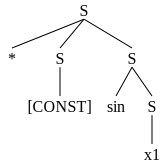

In [19]:
max_ops = 5
nl = 1
p1 = 1
p2 = 1

D = []
D.append([0] + ([nl ** i for i in range(1, 2 * max_ops + 1)]))
for n in range(1, 2 * max_ops + 1):  # number of operators
    s = [0]
    for e in range(1, 2 * max_ops - n + 1):  # number of empty nodes
        s.append(
            nl * s[e - 1]
            + p1 * D[n - 1][e]
            + p2 * D[n - 1][e + 1]
        )
    D.append(s)
assert all(len(D[i]) >= len(D[i + 1]) for i in range(len(D) - 1))
D = [
    [D[j][i] for j in range(len(D)) if i < len(D[j])]
    for i in range(max(len(x) for x in D))
]

ubi_dist = D
ubi_dist

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 2, 6, 22, 90, 394, 1806, 8558, 41586, 206098],
 [1, 4, 16, 68, 304, 1412, 6752, 33028, 164512],
 [1, 6, 30, 146, 714, 3534, 17718, 89898],
 [1, 8, 48, 264, 1408, 7432, 39152],
 [1, 10, 70, 430, 2490, 14002],
 [1, 12, 96, 652, 4080],
 [1, 14, 126, 938],
 [1, 16, 160],
 [1, 18],
 [1]]

In [23]:
import numpy as np

def _sample_next_pos_ubi(nb_empty, nb_ops, rng):
    """
    Sample the position of the next node (unary-binary case).
    Sample a position in {0, ..., `nb_empty` - 1}, along with an arity.
    """
    assert nb_ops > 0
    assert nb_empty > 0
    probs = []
    for i in range(nb_empty):
        probs.append(
            (nl ** i) * p1 * ubi_dist[nb_empty - i][nb_ops - 1]
        )
    for i in range(nb_empty):
        probs.append(
            (nl ** i) * p2 * ubi_dist[nb_empty - i + 1][nb_ops - 1]
        )
    probs = [p / ubi_dist[nb_empty][nb_ops] for p in probs]
    probs = np.array(probs, dtype=np.float64)
    e = rng.choice(2 * nb_empty, p=probs)
    arity = 1 if e < nb_empty else 2
    e = e % nb_empty
    return e, arity

e, arity = _sample_next_pos_ubi(5, 2, np.random.default_rng())
e, arity

(0, 2)

In [16]:
from importlib import reload
import utils
import generator
reload(generator)
reload(utils)
from utils import create_generator
import numpy as np

gen, param = create_generator('./data_settings.json')

gen._generate_expr(5, np.random)

5
['div', None, None]
4
['div', None, 'sub', None, None]
3
['div', None, 'sub', 'add', None, None, None]
2
['div', None, 'sub', 'add', None, None, 'add', None, None]
1
['div', None, 'sub', 'add', None, None, 'add', 'sin', None, None]


['div', 'x1', 'sub', 'add', 'x1', 'c', 'add', 'sin', 'x1', 'x1']

In [24]:
a = 5